In [1]:
import matplotlib.pyplot as plt
import numpy as np
import importlib

from mesa.batchrunner import BatchRunner

import src.model

In [2]:
# run this cell to re-import the Model class
importlib.reload(src.model);

# Single run

In [3]:
model = src.model.Model(
     length=1000,
     lane_width=3.5,
     n_lanes=2,
     flow=0.6,
     max_speed=120,
     car_length=5,
     min_spacing=1,
     car_acc=33 / 10,
     car_dec=33 / 5,
     p_slowdown=0.2,
     time_step=0.1,
     seed=None,
     verbose=0)

for i in range(10000):
    model.step()

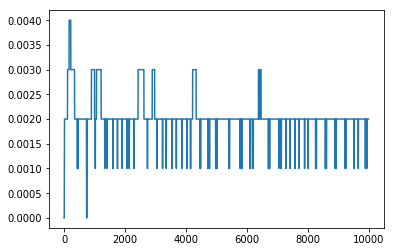

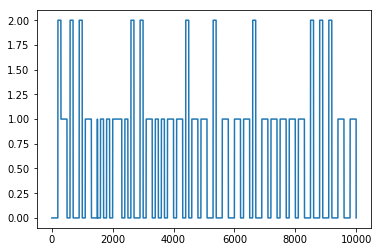

In [4]:
df = model.data_collector.get_model_vars_dataframe()
df.Density.plot()
plt.figure()
df.Flow.plot()

# Batch run

In [5]:
fixed_params = {"length": 1000,
                "lane_width": 3.5,
                "n_lanes": 2,
                #"flow": 0.6,
                "max_speed": 120,
                "car_length": 5,
                "min_spacing": 1,
                "car_acc": 33 / 10,
                "car_dec": 33 / 5,
                "p_slowdown": 0.2,
                "time_step": 0.1,
                "verbose": 0
               }
variable_params = {"flow": np.linspace(0, 1, 5)}

batch_run = BatchRunner(src.model.Model,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=5,
                        max_steps=1000,
                        model_reporters={
                            "Density": src.data.density,
                            "Flow": src.data.flow},
                        agent_reporters={},
                       display_progress=True)
batch_run.run_all()

25it [00:01, 11.73it/s]


Note `BatchRunner` `model_reporters` and `agent_reporters` (unlike the `DataCollector`) won’t collect the data every step of the model, but only at the end of each run.

In [6]:
df = batch_run.get_model_vars_dataframe()
df[["flow", "Density"]]

,flow,Density
0,0.00,0.000
1,0.00,0.000
2,0.00,0.000
3,0.00,0.000
4,0.00,0.000
5,0.25,0.002
6,0.25,0.001
7,0.25,0.002
8,0.25,0.002
9,0.25,0.002
